# 1D Convolutional Neural Network for Regression

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

## Import Data

Use the energy efficiency dataset from UCI.

In [2]:
dataset_path = keras.utils.get_file("ENB2012_data.xlsx", "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")

In [3]:
import pandas as pd

column_names = ['Relative Compactness', 'Surface Area', 'Wall Area', 
                'Roof Area', 'Overall Height', 'Orientation', 
                'Glazing Area', 'Glazing Area Distribution', 
                'Heating Load', 'Cooling Load']
raw_dataset = pd.read_excel(dataset_path, names = column_names, 
                          na_values = '?', comment = '\t', 
                          sep = ' ', skipinitialspace = True)
dataset = raw_dataset.copy()

In [4]:
dataset.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [5]:
dataset.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


## Preprocess data

In [6]:
dataset.isna().sum()
# No NA's

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64

In [7]:
# Split train/test data
total_train = dataset.sample(frac = 0.8, random_state = 0)
total_valid = dataset.drop(total_train.index)

# Predict Heating Load
y_train = total_train.pop('Heating Load')
y_valid = total_valid.pop('Heating Load')
X_train = total_train
X_valid = total_valid

In [8]:
# Normalize
X_train = tf.keras.utils.normalize(X_train, axis = -1, order = 2)
X_valid = tf.keras.utils.normalize(X_valid, axis = -1, order = 2)

In [9]:
X_train.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Cooling Load
661,0.000774,0.890610,0.373482,0.258564,0.004104,0.003518,0.000469,0.003518,0.020673
122,0.000972,0.901183,0.321851,0.289666,0.004598,0.005255,0.000131,0.002627,0.017827
113,0.001069,0.861844,0.464070,0.198887,0.009471,0.004059,0.000135,0.002706,0.046840
14,0.001161,0.867316,0.451004,0.208156,0.009912,0.005664,0.000000,0.000000,0.029963
529,0.001623,0.852222,0.486984,0.182619,0.011595,0.004969,0.000663,0.001656,0.055225


In [10]:
# Reshape
import pandas as pd

X_train = X_train.to_numpy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

## Build model

In [11]:
def build_model():
    model = keras.Sequential([
        layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu', 
                      input_shape = (9, 1)),
        layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size = 2),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    
    optimizer = 'adam'#tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer = optimizer,
                 metrics = ['mae', 'mse'])
    
    return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 32)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

## Train the model

In [14]:
EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(
    X_train, y_train,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = (X_valid, y_valid),
    #callbacks = [early_stop, tfdocs.modeling.EpochDots()]
)

Epoch 1/100
20/20 [==============================] - 1s 75ms/step - loss: 595.9593 - mae: 22.2432 - mse: 595.9593 - val_loss: 499.1138 - val_mae: 19.9486 - val_mse: 499.1138
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 467.8334 - mae: 19.0407 - mse: 467.8334 - val_loss: 310.4649 - val_mae: 14.4825 - val_mse: 310.4649
Epoch 3/100
20/20 [==============================] - 0s 22ms/step - loss: 165.0707 - mae: 10.4988 - mse: 165.0707 - val_loss: 102.7360 - val_mae: 8.6147 - val_mse: 102.7360
Epoch 4/100
20/20 [==============================] - 0s 20ms/step - loss: 105.5047 - mae: 9.0714 - mse: 105.5047 - val_loss: 133.5465 - val_mae: 8.2953 - val_mse: 133.5465
Epoch 5/100
20/20 [==============================] - 0s 24ms/step - loss: 104.1005 - mae: 9.0734 - mse: 104.1005 - val_loss: 119.0559 - val_mae: 8.2562 - val_mse: 119.0559
Epoch 6/100
20/20 [==============================] - 0s 17ms/step - loss: 100.8151 - mae: 8.9815 - mse: 100.8151 - val_loss: 118.7314 -

20/20 [==============================] - 0s 15ms/step - loss: 28.4738 - mae: 4.0065 - mse: 28.4738 - val_loss: 52.3604 - val_mae: 5.5262 - val_mse: 52.3604
Epoch 50/100
20/20 [==============================] - 0s 14ms/step - loss: 27.8411 - mae: 3.9395 - mse: 27.8411 - val_loss: 52.7119 - val_mae: 5.5700 - val_mse: 52.7119
Epoch 51/100
20/20 [==============================] - 0s 19ms/step - loss: 25.2288 - mae: 3.7072 - mse: 25.2288 - val_loss: 56.6114 - val_mae: 5.9157 - val_mse: 56.6114
Epoch 52/100
20/20 [==============================] - 0s 23ms/step - loss: 26.7510 - mae: 3.8805 - mse: 26.7510 - val_loss: 54.4230 - val_mae: 5.7815 - val_mse: 54.4230
Epoch 53/100
20/20 [==============================] - 0s 12ms/step - loss: 27.3678 - mae: 3.9497 - mse: 27.3678 - val_loss: 48.6634 - val_mae: 5.3510 - val_mse: 48.6634
Epoch 54/100
20/20 [==============================] - 0s 14ms/step - loss: 28.1253 - mae: 3.9724 - mse: 28.1253 - val_loss: 58.3092 - val_mae: 6.0285 - val_mse: 58.3092

20/20 [==============================] - 0s 23ms/step - loss: 25.2881 - mae: 3.6969 - mse: 25.2881 - val_loss: 58.2835 - val_mae: 5.9750 - val_mse: 58.2835
Epoch 98/100
20/20 [==============================] - 0s 16ms/step - loss: 25.7519 - mae: 3.7796 - mse: 25.7519 - val_loss: 55.6405 - val_mae: 5.8187 - val_mse: 55.6405
Epoch 99/100
20/20 [==============================] - 0s 21ms/step - loss: 24.5845 - mae: 3.6836 - mse: 24.5845 - val_loss: 60.8039 - val_mae: 6.1722 - val_mse: 60.8039
Epoch 100/100
20/20 [==============================] - 0s 22ms/step - loss: 26.0673 - mae: 3.7084 - mse: 26.0673 - val_loss: 67.7368 - val_mae: 6.6218 - val_mse: 67.7368


## Evaluate the model

5/5 - 0s - loss: 67.7368 - mae: 6.6218 - mse: 67.7368


[67.73677062988281, 6.621764183044434, 67.73677062988281]

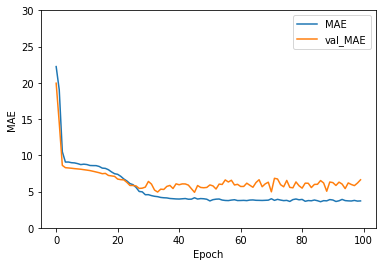

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label = 'MAE')
plt.plot(history.history['val_mae'], label = 'val_MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim([0, 30])
plt.legend(loc = 'upper right')

model.evaluate(X_valid, y_valid, verbose = 2)

5/5 - 0s - loss: 67.7368 - mae: 6.6218 - mse: 67.7368


[67.73677062988281, 6.621764183044434, 67.73677062988281]

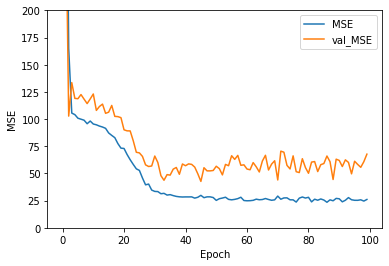

In [16]:
plt.plot(history.history['mse'], label = 'MSE')
plt.plot(history.history['val_mse'], label = 'val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 200])
plt.legend(loc = 'upper right')

model.evaluate(X_valid, y_valid, verbose = 2)

## Make predictions

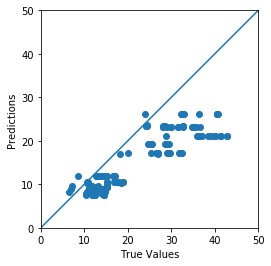

In [17]:
preds = model.predict(X_valid).flatten()

a = plt.axes(aspect = 'equal')
plt.scatter(y_valid, preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

View error distribution.

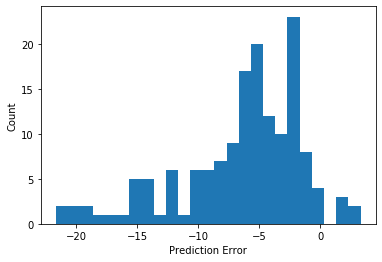

In [18]:
error = preds - y_valid
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")